In [5]:
import scanpy as sc
import surgeon
sc.settings.set_figure_params(dpi=200, frameon=False)

In [6]:
condition_key = "sample"
cell_type_key = 'celltype'
target_condition = "Segerstolpe"

# Loading four pancrease datasets and data preparation

In [7]:
adata = sc.read("./data/pancreas/pancreas.h5ad")
cell_types = ['alpha', 'beta', 'ductal', 'acinar',
              'delta', 'gamma', 'endothelial', 'activated_stellate',
              'quiescent_stellate', 'macrophage',
              'mast', 'epsilon', 'schwann']
adata = adata[adata.obs[cell_type_key].isin(cell_types)]

## Number of cells in each batch

In [8]:
adata.obs[condition_key].value_counts()

Baron          8562
Segerstolpe    2068
Muraro         2042
Wang            430
Name: sample, dtype: int64

## visualization  of the original data

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


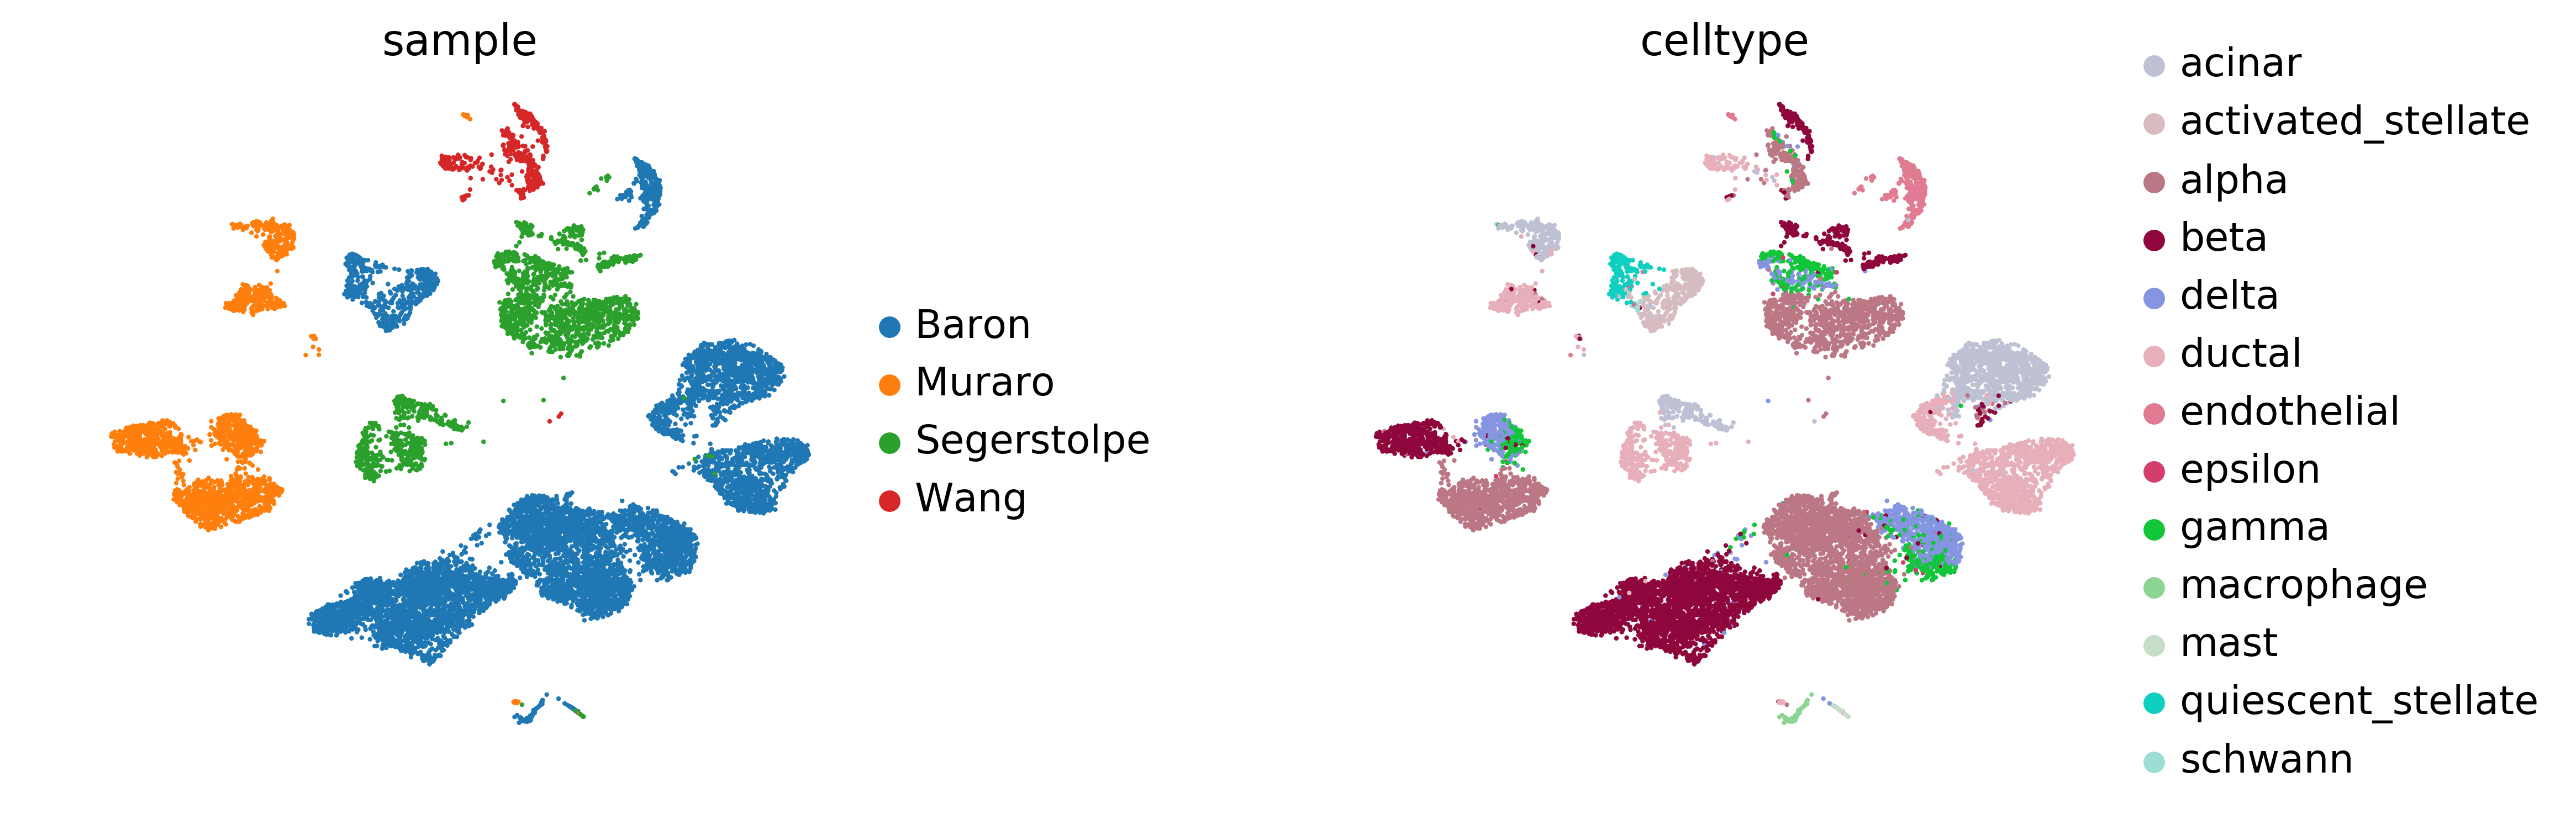

In [21]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (Segerstolpe) for training the newtork

In [9]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 11034 × 2448 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

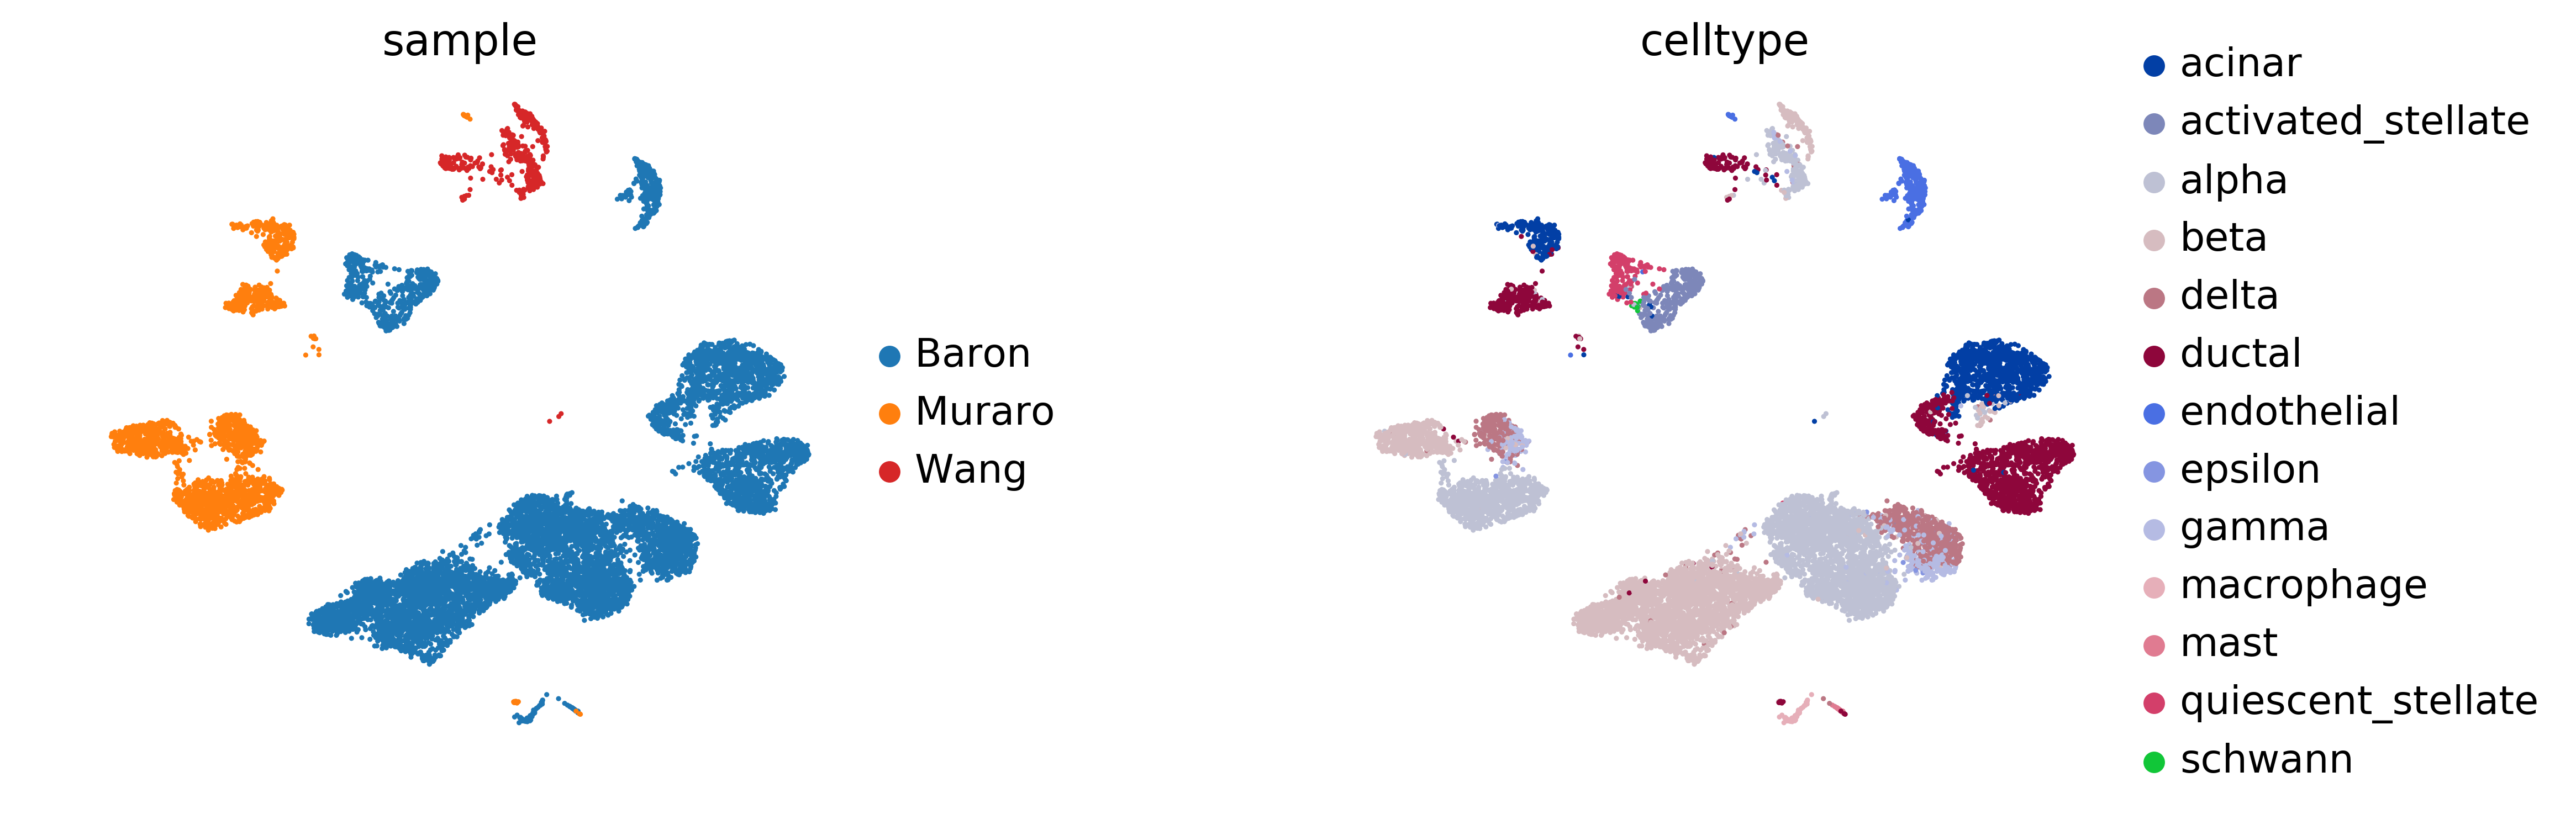

In [20]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [10]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 2068 × 2448 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Train/Test Split

In [11]:
train_adata, valid_adata = surgeon.utils.train_test_split(
    adata_for_training, 0.85)

In [12]:
train_adata.shape, valid_adata.shape

((9378, 2448), (1656, 2448))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [14]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/Pancreas_pretrain/",
                             dropout_rate=0.2,
                             output_activation='linear')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2451)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1254912     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [15]:
condition_encoder = {'Baron': 0, 'Muraro': 1, 'Wang': 2}

## Training the network

In [16]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              le=condition_encoder,
              n_epochs=300,
              batch_size=128,
              early_stop_limit=20,
              lr_reducer=15,
              save=True,
              verbose=2)

Train on 9378 samples, validate on 1656 samples
Epoch 1/300
 - 2s - loss: 884.7555 - kl_recon_loss: 884.7555 - val_loss: 839.8209 - val_kl_recon_loss: 839.8209
Epoch 2/300
 - 0s - loss: 799.2226 - kl_recon_loss: 799.2226 - val_loss: 795.6121 - val_kl_recon_loss: 795.6121
Epoch 3/300
 - 0s - loss: 785.1429 - kl_recon_loss: 785.1429 - val_loss: 772.7642 - val_kl_recon_loss: 772.7642
Epoch 4/300
 - 0s - loss: 775.2541 - kl_recon_loss: 775.2541 - val_loss: 763.6558 - val_kl_recon_loss: 763.6558
Epoch 5/300
 - 0s - loss: 768.9952 - kl_recon_loss: 768.9952 - val_loss: 759.6240 - val_kl_recon_loss: 759.6240
Epoch 6/300
 - 0s - loss: 764.5767 - kl_recon_loss: 764.5767 - val_loss: 755.1845 - val_kl_recon_loss: 755.1845
Epoch 7/300
 - 1s - loss: 761.0266 - kl_recon_loss: 761.0266 - val_loss: 751.9331 - val_kl_recon_loss: 751.9331
Epoch 8/300
 - 0s - loss: 755.9568 - kl_recon_loss: 755.9568 - val_loss: 749.1186 - val_kl_recon_loss: 749.1186
Epoch 9/300
 - 0s - loss: 753.5890 - kl_recon_loss: 753.

Epoch 74/300
 - 0s - loss: 720.7429 - kl_recon_loss: 720.7429 - val_loss: 721.7396 - val_kl_recon_loss: 721.7396
Epoch 75/300
 - 1s - loss: 720.2702 - kl_recon_loss: 720.2702 - val_loss: 720.3503 - val_kl_recon_loss: 720.3503
Epoch 76/300
 - 1s - loss: 719.8658 - kl_recon_loss: 719.8658 - val_loss: 721.0639 - val_kl_recon_loss: 721.0639
Epoch 77/300
 - 1s - loss: 720.1067 - kl_recon_loss: 720.1067 - val_loss: 720.9155 - val_kl_recon_loss: 720.9155
Epoch 78/300
 - 1s - loss: 720.0518 - kl_recon_loss: 720.0518 - val_loss: 720.0643 - val_kl_recon_loss: 720.0643
Epoch 79/300
 - 1s - loss: 720.1148 - kl_recon_loss: 720.1148 - val_loss: 720.2836 - val_kl_recon_loss: 720.2836
Epoch 80/300
 - 1s - loss: 719.8508 - kl_recon_loss: 719.8508 - val_loss: 720.4080 - val_kl_recon_loss: 720.4080
Epoch 81/300
 - 0s - loss: 720.1163 - kl_recon_loss: 720.1163 - val_loss: 720.0194 - val_kl_recon_loss: 720.0194
Epoch 82/300
 - 1s - loss: 719.4379 - kl_recon_loss: 719.4379 - val_loss: 719.8532 - val_kl_reco

 - 0s - loss: 715.7082 - kl_recon_loss: 715.7082 - val_loss: 717.9879 - val_kl_recon_loss: 717.9879
Epoch 147/300
 - 0s - loss: 715.9068 - kl_recon_loss: 715.9068 - val_loss: 717.8273 - val_kl_recon_loss: 717.8273
Epoch 148/300
 - 0s - loss: 716.0998 - kl_recon_loss: 716.0998 - val_loss: 717.9388 - val_kl_recon_loss: 717.9388
Epoch 149/300
 - 1s - loss: 716.0798 - kl_recon_loss: 716.0798 - val_loss: 717.8665 - val_kl_recon_loss: 717.8665
Epoch 150/300
 - 0s - loss: 715.7638 - kl_recon_loss: 715.7638 - val_loss: 717.6667 - val_kl_recon_loss: 717.6667
Epoch 151/300
 - 1s - loss: 715.8542 - kl_recon_loss: 715.8542 - val_loss: 718.2480 - val_kl_recon_loss: 718.2480
Epoch 152/300
 - 0s - loss: 716.1642 - kl_recon_loss: 716.1642 - val_loss: 717.6560 - val_kl_recon_loss: 717.6560
Epoch 153/300
 - 0s - loss: 715.4443 - kl_recon_loss: 715.4443 - val_loss: 717.8127 - val_kl_recon_loss: 717.8127
Epoch 154/300
 - 0s - loss: 715.7772 - kl_recon_loss: 715.7772 - val_loss: 718.1657 - val_kl_recon_los

Epoch 218/300
 - 0s - loss: 710.4160 - kl_recon_loss: 710.4160 - val_loss: 715.6416 - val_kl_recon_loss: 715.6416
Epoch 219/300
 - 0s - loss: 710.6295 - kl_recon_loss: 710.6295 - val_loss: 715.6043 - val_kl_recon_loss: 715.6043
Epoch 220/300
 - 0s - loss: 710.4165 - kl_recon_loss: 710.4165 - val_loss: 715.6066 - val_kl_recon_loss: 715.6066
Epoch 221/300
 - 0s - loss: 710.6016 - kl_recon_loss: 710.6016 - val_loss: 715.6620 - val_kl_recon_loss: 715.6620
Epoch 222/300
 - 0s - loss: 710.3928 - kl_recon_loss: 710.3928 - val_loss: 715.5626 - val_kl_recon_loss: 715.5626
Epoch 223/300
 - 0s - loss: 710.5998 - kl_recon_loss: 710.5998 - val_loss: 715.6078 - val_kl_recon_loss: 715.6078
Epoch 224/300
 - 0s - loss: 710.4720 - kl_recon_loss: 710.4720 - val_loss: 715.5624 - val_kl_recon_loss: 715.5624
Epoch 225/300
 - 1s - loss: 710.3270 - kl_recon_loss: 710.3270 - val_loss: 715.5240 - val_kl_recon_loss: 715.5240
Epoch 226/300
 - 1s - loss: 710.8245 - kl_recon_loss: 710.8245 - val_loss: 715.5876 - va

Epoch 290/300
 - 0s - loss: 709.7264 - kl_recon_loss: 709.7264 - val_loss: 715.3308 - val_kl_recon_loss: 715.3308
Epoch 291/300
 - 0s - loss: 710.0920 - kl_recon_loss: 710.0920 - val_loss: 715.2546 - val_kl_recon_loss: 715.2546
Epoch 292/300
 - 0s - loss: 709.8656 - kl_recon_loss: 709.8656 - val_loss: 715.3089 - val_kl_recon_loss: 715.3089
Epoch 293/300
 - 0s - loss: 710.0686 - kl_recon_loss: 710.0686 - val_loss: 715.1916 - val_kl_recon_loss: 715.1916
Epoch 294/300
 - 0s - loss: 709.7261 - kl_recon_loss: 709.7261 - val_loss: 715.2566 - val_kl_recon_loss: 715.2566
Epoch 295/300
 - 0s - loss: 709.8577 - kl_recon_loss: 709.8577 - val_loss: 715.2384 - val_kl_recon_loss: 715.2384
Epoch 296/300
 - 0s - loss: 710.1595 - kl_recon_loss: 710.1595 - val_loss: 715.2097 - val_kl_recon_loss: 715.2097
Epoch 297/300
 - 0s - loss: 709.9397 - kl_recon_loss: 709.9397 - val_loss: 715.3459 - val_kl_recon_loss: 715.3459
Epoch 298/300
 - 1s - loss: 710.1091 - kl_recon_loss: 710.1091 - val_loss: 715.2121 - va

In [17]:
network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2}

In [18]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [19]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9378 × 10 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


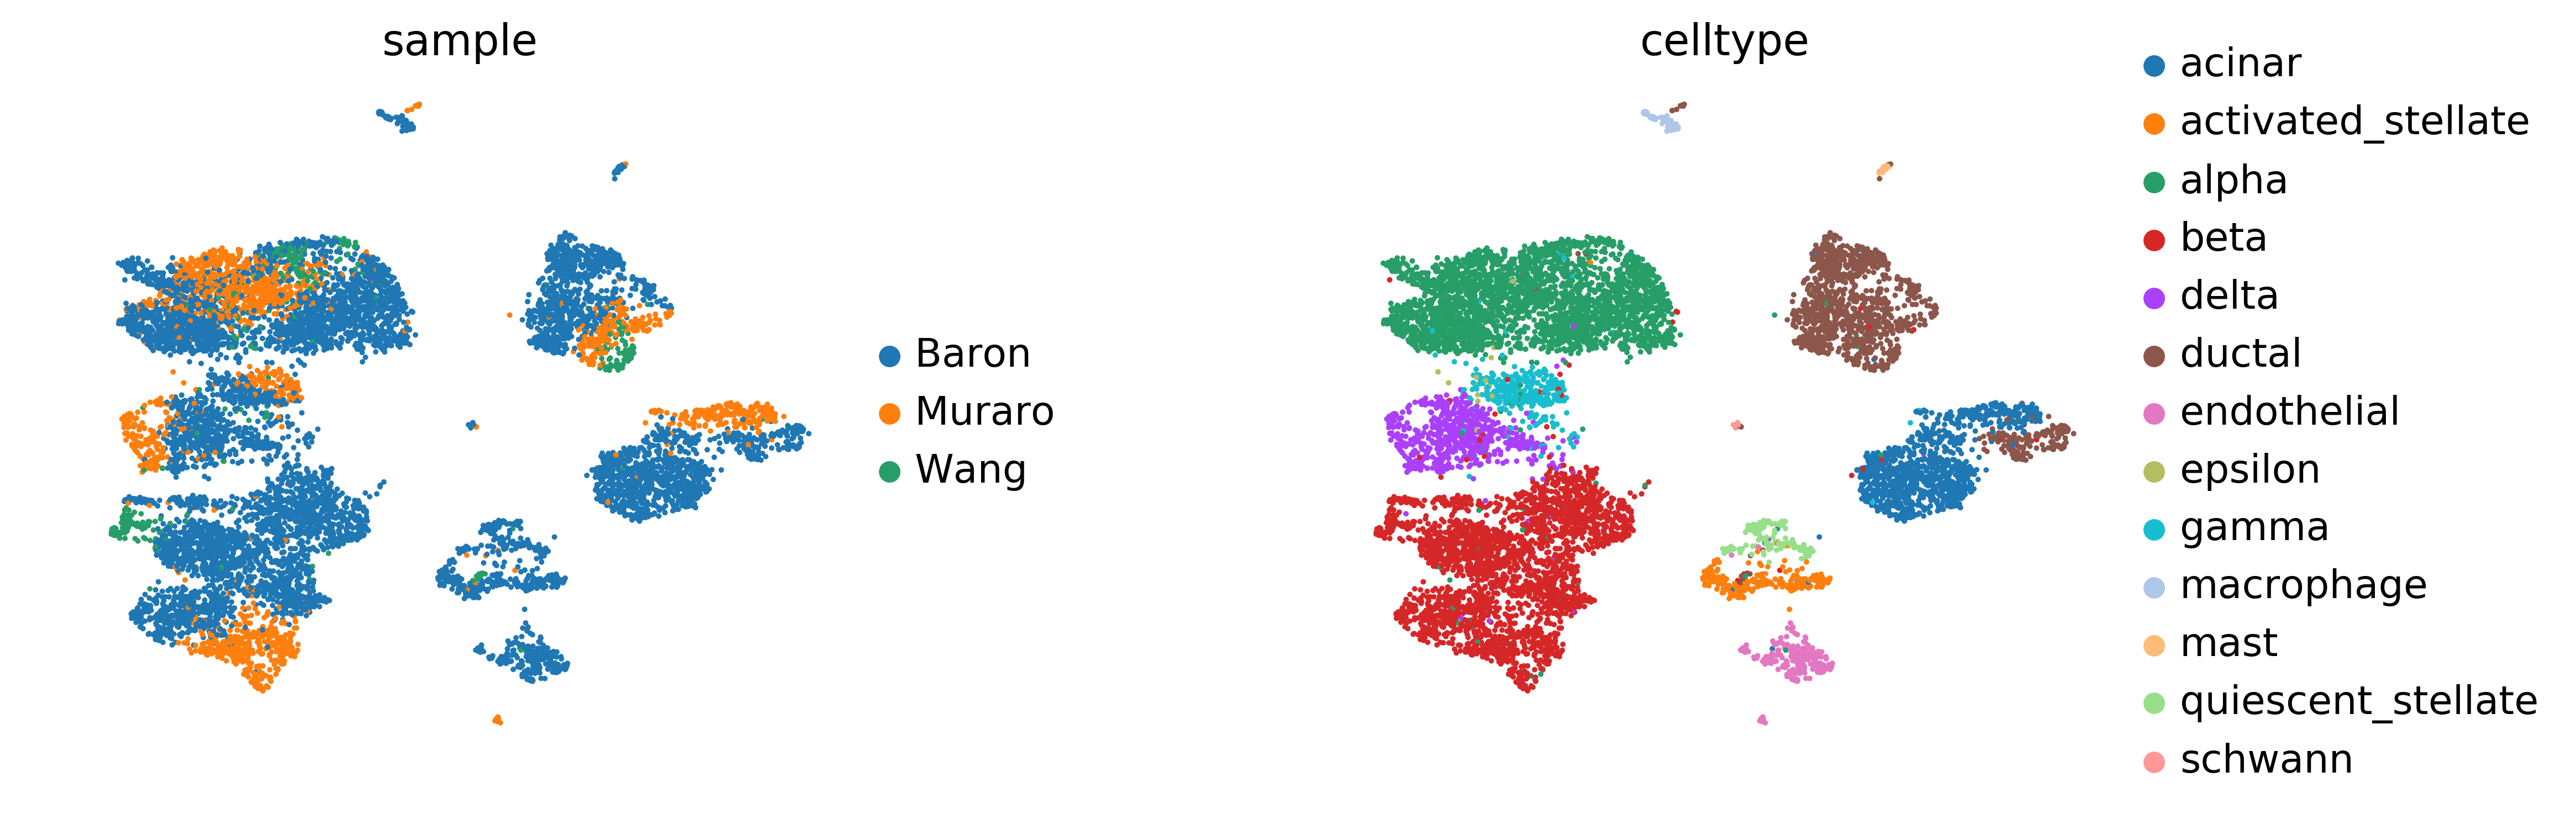

In [21]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [22]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

In [23]:
new_network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2, 'Segerstolpe': 3}

## Train with small new dataset containing out-of-sample condition

In [24]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [25]:
train_adata.shape, valid_adata.shape

((1757, 2448), (311, 2448))

In [27]:
new_network.model_path = './models/CVAE/Pancreas_pretrain/Segerstolpe'

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=128, 
                  early_stop_limit=50,
                  lr_reducer=15, 
                  save=False, 
                  verbose=2)

Train on 1757 samples, validate on 311 samples
Epoch 1/300
 - 1s - loss: 909.7689 - kl_recon_loss: 909.7689 - val_loss: 903.4786 - val_kl_recon_loss: 903.4786
Epoch 2/300
 - 0s - loss: 903.9210 - kl_recon_loss: 903.9210 - val_loss: 898.9871 - val_kl_recon_loss: 898.9871
Epoch 3/300
 - 0s - loss: 901.4577 - kl_recon_loss: 901.4577 - val_loss: 897.2104 - val_kl_recon_loss: 897.2104
Epoch 4/300
 - 0s - loss: 899.0743 - kl_recon_loss: 899.0743 - val_loss: 896.2438 - val_kl_recon_loss: 896.2438
Epoch 5/300
 - 0s - loss: 897.5959 - kl_recon_loss: 897.5959 - val_loss: 895.1543 - val_kl_recon_loss: 895.1543
Epoch 6/300
 - 0s - loss: 896.0878 - kl_recon_loss: 896.0878 - val_loss: 894.4905 - val_kl_recon_loss: 894.4905
Epoch 7/300
 - 0s - loss: 895.8642 - kl_recon_loss: 895.8642 - val_loss: 893.5492 - val_kl_recon_loss: 893.5492
Epoch 8/300
 - 0s - loss: 894.8820 - kl_recon_loss: 894.8820 - val_loss: 894.0346 - val_kl_recon_loss: 894.0346
Epoch 9/300
 - 0s - loss: 895.3124 - kl_recon_loss: 895.3

Epoch 74/300
 - 0s - loss: 887.5660 - kl_recon_loss: 887.5660 - val_loss: 891.5678 - val_kl_recon_loss: 891.5678
Epoch 75/300
 - 0s - loss: 887.3121 - kl_recon_loss: 887.3121 - val_loss: 891.5512 - val_kl_recon_loss: 891.5512
Epoch 76/300
 - 0s - loss: 888.7432 - kl_recon_loss: 888.7432 - val_loss: 891.6543 - val_kl_recon_loss: 891.6543
Epoch 77/300
 - 0s - loss: 889.0822 - kl_recon_loss: 889.0822 - val_loss: 891.6978 - val_kl_recon_loss: 891.6978
Epoch 78/300
 - 0s - loss: 887.7502 - kl_recon_loss: 887.7502 - val_loss: 891.6349 - val_kl_recon_loss: 891.6349
Epoch 79/300
 - 0s - loss: 888.5420 - kl_recon_loss: 888.5420 - val_loss: 891.5903 - val_kl_recon_loss: 891.5903
Epoch 80/300
 - 0s - loss: 888.8893 - kl_recon_loss: 888.8893 - val_loss: 891.5174 - val_kl_recon_loss: 891.5174
Epoch 81/300
 - 0s - loss: 889.5410 - kl_recon_loss: 889.5410 - val_loss: 891.4704 - val_kl_recon_loss: 891.4704
Epoch 82/300
 - 0s - loss: 888.0200 - kl_recon_loss: 888.0200 - val_loss: 891.4867 - val_kl_reco

 - 0s - loss: 888.8207 - kl_recon_loss: 888.8207 - val_loss: 891.1750 - val_kl_recon_loss: 891.1750
Epoch 147/300
 - 0s - loss: 887.9962 - kl_recon_loss: 887.9962 - val_loss: 891.2262 - val_kl_recon_loss: 891.2262
Epoch 148/300
 - 0s - loss: 888.5354 - kl_recon_loss: 888.5354 - val_loss: 891.2771 - val_kl_recon_loss: 891.2771
Epoch 149/300
 - 0s - loss: 889.3101 - kl_recon_loss: 889.3101 - val_loss: 891.3376 - val_kl_recon_loss: 891.3376
Epoch 150/300
 - 0s - loss: 887.6079 - kl_recon_loss: 887.6079 - val_loss: 891.3742 - val_kl_recon_loss: 891.3742
Epoch 151/300
 - 0s - loss: 889.3860 - kl_recon_loss: 889.3860 - val_loss: 891.3511 - val_kl_recon_loss: 891.3511
Epoch 152/300
 - 0s - loss: 888.6515 - kl_recon_loss: 888.6515 - val_loss: 891.3506 - val_kl_recon_loss: 891.3506
Epoch 153/300
 - 0s - loss: 888.3854 - kl_recon_loss: 888.3854 - val_loss: 891.3935 - val_kl_recon_loss: 891.3935
Epoch 154/300
 - 0s - loss: 889.7675 - kl_recon_loss: 889.7675 - val_loss: 891.3142 - val_kl_recon_los

## Projecting all data in to the latent space of the model 

In [29]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [30]:
adata.obs[condition_key].value_counts()

Baron          8562
Segerstolpe    2068
Muraro         2042
Wang            430
Name: sample, dtype: int64

In [31]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 13102 × 10 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

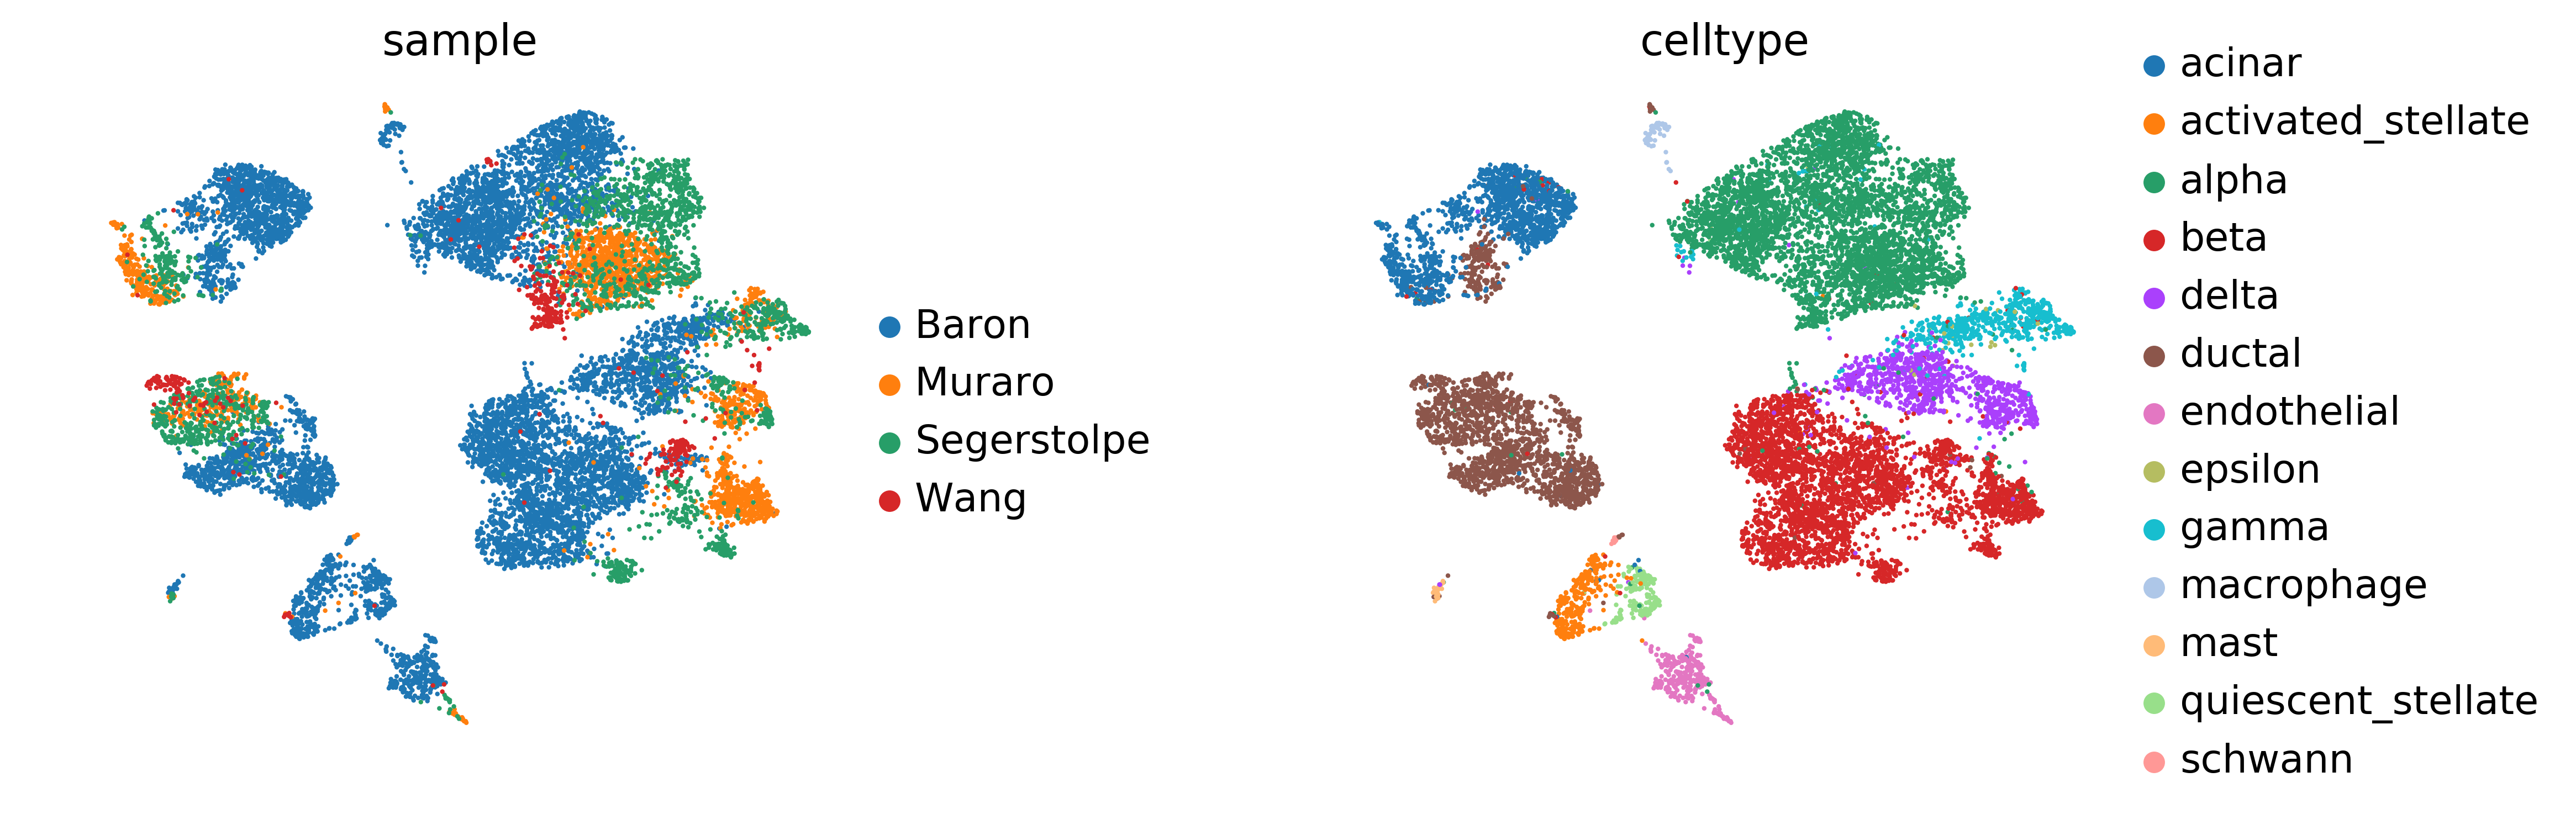

In [33]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)